In [ ]:
# importing any necessary libraries/packages

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import itertools
import os
from firecloud import api as fapi
from io import StringIO


## Setup

In [ ]:
# make sure we're in the workspace we want to be in

funding = os.environ['WORKSPACE_NAMESPACE']
workspace = os.environ['WORKSPACE_NAME']
print(workspace)


In [ ]:
# import terra data table

response = fapi.get_entities_tsv(funding,workspace,"viral_stock",model="flexible")
stock_vcf_files = pd.read_csv(StringIO(response.text),sep="\t", index_col="entity:viral_stock_id")
stock_vcf_files.head()


In [ ]:
files = list(stock_vcf_files['lofreq_vcf_qchike'])
samples = list(stock_vcf_files.index)

all_iSNV_list = []
for file,rep in zip(files,samples):
    df = pd.read_table(file,sep='\t',skiprows=15)
    df['replicate'] = rep
    all_iSNV_list.append(df)
lofreq_isnvs_rep = pd.concat(all_iSNV_list, ignore_index=True, axis=0)

lofreq_isnvs_rep[['depth','freq','qual','reads']] = lofreq_isnvs_rep['INFO'].str.split(';', 3, expand=True)
lofreq_isnvs_rep = lofreq_isnvs_rep.reset_index(drop=True)

lofreq_isnvs_rep['depth'] = lofreq_isnvs_rep['depth'].str[3:]
lofreq_isnvs_rep['freq'] = lofreq_isnvs_rep['freq'].str[3:]

lofreq_isnvs_rep[["depth", "freq"]] = lofreq_isnvs_rep[["depth", "freq"]].apply(pd.to_numeric)
lofreq_isnvs_rep['variant_reads'] = round(lofreq_isnvs_rep['depth']*lofreq_isnvs_rep['freq'])

lofreq_isnvs_rep['alleles'] = lofreq_isnvs_rep['REF']+lofreq_isnvs_rep['ALT']

lofreq_isnvs_rep.head()


In [22]:
# filtering for minimum depth (100), variant reads (5), freq (0.001)

lofreq_isnvs_rep = lofreq_isnvs_rep[(lofreq_isnvs_rep['depth']>100)&(lofreq_isnvs_rep['freq']>0.005)&(lofreq_isnvs_rep['variant_reads']>5)]


In [23]:
# this block puts replicate variant stats on the same row

#temp_df = lofreq_isnvs[['POS','sample','library','REF','ALT','freq','depth','variant_reads','depths']]
temp_df = lofreq_isnvs_rep[['POS','replicate','REF','ALT','freq','depth','variant_reads']]

#df_lib_1 = temp_df[temp_df['replicate']=='S1.GDJM5.1']
#df_lib_1 = df_lib_1[['POS','replicate','REF','ALT','freq','depth','variant_reads']]
#df_lib_1 = df_lib_1.rename(columns={"freq": "rep1_freq", "depth": "rep1_depth",'variant_reads':'rep1_variant_reads','REF':'rep1_ref','ALT':'rep1_alt'})

df_lib_1 = temp_df[temp_df['replicate']=='S4.GDJM5.1']
df_lib_1 = df_lib_1[['POS','replicate','REF','ALT','freq','depth','variant_reads']]
df_lib_1 = df_lib_1.rename(columns={"freq": "rep3_freq", "depth": "rep3_depth",'variant_reads':'rep3_variant_reads','REF':'rep3_ref','ALT':'rep3_alt'})

df_lib_2 = temp_df[temp_df['replicate']=='S3.GDJM5.1']
df_lib_2 = df_lib_2[['POS','replicate','REF','ALT','freq','depth','variant_reads']]
df_lib_2 = df_lib_2.rename(columns={"freq": "rep2_freq", "depth": "rep2_depth",'variant_reads':'rep2_variant_reads','REF':'rep2_ref','ALT':'rep2_alt'})

merged1 = pd.merge(df_lib_1,df_lib_2, on=['POS'],how='left')
merged2 = pd.merge(df_lib_1,df_lib_2, on=['POS'],how='right')

merged_comb = merged1.append(merged2, ignore_index=True)

#merged_comb = merged_comb.drop_duplicates()
isnvs_set_final = merged_comb.drop_duplicates()
isnvs_set_final = isnvs_set_final.fillna(0)

isnvs_set_final['merged_freq'] = (isnvs_set_final['rep2_variant_reads']+isnvs_set_final['rep3_variant_reads'])/(isnvs_set_final['rep2_depth']+isnvs_set_final['rep3_depth'])

isnvs_set_final.head()


,POS,replicate_x,rep3_ref,rep3_alt,rep3_freq,rep3_depth,rep3_variant_reads,replicate_y,rep2_ref,rep2_alt,rep2_freq,rep2_depth,rep2_variant_reads,merged_freq
0,564,S4.GDJM5.1,A,G,0.007935,16006.0,127.0,S3.GDJM5.1,A,G,0.008083,16579.0,134.0,0.008010
1,688,S4.GDJM5.1,C,T,0.005683,17421.0,99.0,S3.GDJM5.1,C,T,0.006049,18516.0,112.0,0.005871
2,1240,S4.GDJM5.1,G,A,0.005484,17871.0,98.0,0,0,0,0.000000,0.0,0.0,0.005484
3,1588,S4.GDJM5.1,G,A,0.006109,12114.0,74.0,S3.GDJM5.1,G,A,0.006968,12486.0,87.0,0.006545
4,2829,S4.GDJM5.1,G,A,0.006442,2639.0,17.0,S3.GDJM5.1,G,A,0.007887,2409.0,19.0,0.007132


In [24]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(set(list1)) + len(set(list2))) - intersection
    return float(intersection) / union


In [25]:
# number of total variants across two replicates
len(isnvs_set_final)


30

In [26]:
rep3set = list(set(isnvs_set_final[isnvs_set_final['replicate_x']!=0]['POS']))
rep2set = list(set(isnvs_set_final[isnvs_set_final['replicate_y']!=0]['POS']))


In [27]:
# jaccard similarity between sets
jaccard_similarity(rep3set,rep2set)


0.7

In [28]:
isnvs_set_final = isnvs_set_final[(isnvs_set_final['replicate_x']!=0)&(isnvs_set_final['replicate_y']!=0)]


In [29]:
isnvs_set_final


,POS,replicate_x,rep3_ref,rep3_alt,rep3_freq,rep3_depth,rep3_variant_reads,replicate_y,rep2_ref,rep2_alt,rep2_freq,rep2_depth,rep2_variant_reads,merged_freq
0,564,S4.GDJM5.1,A,G,0.007935,16006.0,127.0,S3.GDJM5.1,A,G,0.008083,16579.0,134.0,0.008010
1,688,S4.GDJM5.1,C,T,0.005683,17421.0,99.0,S3.GDJM5.1,C,T,0.006049,18516.0,112.0,0.005871
3,1588,S4.GDJM5.1,G,A,0.006109,12114.0,74.0,S3.GDJM5.1,G,A,0.006968,12486.0,87.0,0.006545
4,2829,S4.GDJM5.1,G,A,0.006442,2639.0,17.0,S3.GDJM5.1,G,A,0.007887,2409.0,19.0,0.007132
5,3485,S4.GDJM5.1,G,A,0.010544,10432.0,110.0,S3.GDJM5.1,G,A,0.010116,10973.0,111.0,0.010325
6,4435,S4.GDJM5.1,C,T,0.006207,4833.0,30.0,S3.GDJM5.1,C,T,0.007174,4182.0,30.0,0.006656
7,4715,S4.GDJM5.1,G,A,0.006792,17963.0,122.0,S3.GDJM5.1,G,A,0.006822,19055.0,130.0,0.006807
9,6231,S4.GDJM5.1,T,C,0.020884,12833.0,268.0,S3.GDJM5.1,T,C,0.019904,13364.0,266.0,0.020384
10,6325,S4.GDJM5.1,T,C,0.006813,15998.0,109.0,S3.GDJM5.1,T,C,0.007474,16724.0,125.0,0.007151
11,6384,S4.GDJM5.1,C,A,0.007687,21075.0,162.0,S3.GDJM5.1,C,A,0.007143,22398.0,160.0,0.007407


NameError: name 'shared' is not defined

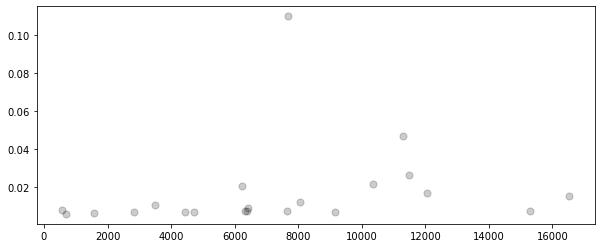

In [30]:
plt.figure(figsize=(10,4))
plt.scatter(isnvs_set_final['POS'],isnvs_set_final['merged_freq'],s=50,alpha=0.2,color='black')
plt.scatter(shared['POS'],shared['merged_freq'],s=50,alpha=0.6,color='blue')
plt.scatter(sing['POS'],sing['merged_freq'],s=50,alpha=0.6,color='red')

plt.yscale('log')
plt.xlabel('EBOV position')
plt.ylabel('variant frequency')


### Exploration of global stock features

In [31]:
lofreq_isnvs_rep['alleles'].value_counts()

GA    29
TC    15
AC    13
CA     6
CT     6
AG     4
Name: alleles, dtype: int64

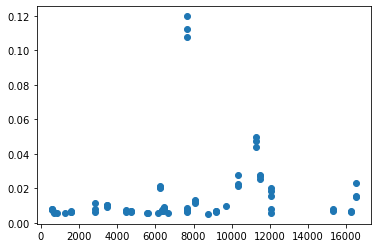

In [32]:
plt.scatter(lofreq_isnvs_rep['POS'],lofreq_isnvs_rep['freq'])

## analysis against animals

### shared variants in stock?

In [4]:
shared_df = pd.read_table('gs://fc-1938e4b2-7a5d-462d-8cbc-e2bae0e3f066/shared_variants_all.csv',sep=',')
shared_df.head()


,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,description,animal,cohort,tissue,depth,freq,qual,reads,variant_reads,alleles
0,KU182905.1,7668,.,T,C,1716,PASS,"DP=1942;AF=0.044284;SB=7;DP4=1003,842,42,48",Spleen_RA1803_D006,RA1803,D006,Spleen,1942,0.044284,SB=7,"DP4=1003,842,42,48",86.0,TC
1,KU182905.1,10343,.,C,A,332,PASS,"DP=646;AF=0.029412;SB=0;DP4=278,345,9,13",Spleen_RA1803_D006,RA1803,D006,Spleen,646,0.029412,SB=0,"DP4=278,345,9,13",19.0,CA
2,KU182905.1,11282,.,A,C,861,PASS,"DP=1065;AF=0.042254;SB=0;DP4=609,409,27,19",Spleen_RA1803_D006,RA1803,D006,Spleen,1065,0.042254,SB=0,"DP4=609,409,27,19",45.0,AC
3,KU182905.1,7668,.,T,C,996,PASS,"DP=778;AF=0.060411;SB=8;DP4=359,365,30,19",Liver_RA1803_D006,RA1803,D006,Liver,778,0.060411,SB=8,"DP4=359,365,30,19",47.0,TC
4,KU182905.1,7668,.,T,C,2687,PASS,"DP=1544;AF=0.077720;SB=0;DP4=633,778,57,71",Spleen_RA0717_D004,RA0717,D004,Spleen,1544,0.077720,SB=0,"DP4=633,778,57,71",120.0,TC


In [34]:
# shared variants confirmed to be in stock

for pos in list(set(shared_df['POS'])):
    if pos in list(set(lofreq_isnvs_rep['POS'])):
        print(pos)


12064
12066
10343
16526
16239
11282
8050
7668
6231


In [35]:
# shared variants that are NOT in stock

for pos in list(set(shared_df['POS'])):
    if pos in list(set(lofreq_isnvs_rep['POS'])):
        x = pos
    else:
        print(pos)
        

5077
502


In [36]:
shared = isnvs_set_final[isnvs_set_final['POS'].isin(list(set(shared_df['POS'])))]

### unique variants in stock?

In [5]:
sing_df = pd.read_table('gs://fc-1938e4b2-7a5d-462d-8cbc-e2bae0e3f066/emergent_variants_all_annotated.csv',sep=',')
sing_df.head()


,#CHROM,POS,gene,gene_transcript,gene_note,type,ID,REF,ALT,QUAL,...,description,animal,cohort,tissue,depth,freq,qual,reads,variant_reads,alleles
0,KU182905.1,169,UTR,NP,NP 5'UTR,noncoding,.,A,G,569,...,Spleen_RA1779_D008,RA1779,D008,Spleen,463,0.058315,SB=6,"DP4=422,12,27,2",27,AG
1,KU182905.1,169,UTR,NP,NP 5'UTR,noncoding,.,A,G,149,...,Lymph node 3_RA1779_D008,RA1779,D008,Lymph node (mes),268,0.029851,SB=2,"DP4=238,22,7,1",8,AG
2,KU182905.1,169,UTR,NP,NP 5'UTR,noncoding,.,A,G,148,...,Whole blood_D008_RA1779_D008,RA1779,D008,Whole blood (D008),138,0.050725,SB=14,"DP4=126,4,6,2",7,AG
3,KU182905.1,1856,NP,NP,NaN,nonsynonymous,.,G,A,989,...,Lymph node 3_RA1779_D008,RA1779,D008,Lymph node (mes),2394,0.025480,SB=5,"DP4=2036,290,62,5",61,GA
4,KU182905.1,2340,NP,NP,NaN,nonsynonymous,.,A,T,2907,...,Lymph node 3_RA1818_D006,RA1818,D006,Lymph node (mes),5438,0.030158,SB=17,"DP4=910,4355,42,130",164,AT


In [38]:
# unique variants confirmed to be in stock

for pos in list(set(sing_df['POS'])):
    if pos in list(set(lofreq_isnvs_rep['POS'])):
        print(pos)
        print(list(lofreq_isnvs_rep[lofreq_isnvs_rep['POS']==pos]['freq']))


7648
[0.00825, 0.007462, 0.007025]


In [39]:
len(list(set(lofreq_isnvs_rep['POS'])))

32

In [40]:
len(list(set(lofreq_isnvs_rep[(lofreq_isnvs_rep['POS']>5900)&(lofreq_isnvs_rep['POS']<8305)]['POS'])))

10

In [41]:
39/184

0.21195652173913043

In [42]:
len(list(set(lofreq_isnvs_rep['POS'])))

32

In [43]:
# unique variants that are NOT in stock

for pos in list(set(sing_df['POS'])):
    if pos in list(set(lofreq_isnvs_rep['POS'])):
        x = pos
    else:
        print(pos)
        

10243
7691
16909
9238
13338
16929
5667
6695
11820
5165
5166
12341
9782
14390
10304
12353
10832
11350
4183
17496
12380
8811
15468
4205
11891
3197
18562
10890
14988
18584
15001
11425
4258
6819
5796
16551
169
4277
4791
6338
18631
10443
17621
6870
17625
8931
6890
3311
6386
16653
11554
2340
7974
15151
17202
8502
1856
3905
16712
9568
4453
2408
8046
9586
8565
6010
8573
4477
11138
14211
13188
16268
18831
2458
14235
9129
4531
7603
2997
9651
9654
17847
5052
12221
7102
6592
7104
5059
7109
13770
10187
14298
3551
18911
8168
3049
3050
18411
16368


In [44]:
lofreq_isnvs_rep['alleles'].value_counts()

GA    29
TC    15
AC    13
CA     6
CT     6
AG     4
Name: alleles, dtype: int64

In [36]:
sing_df['alleles'].value_counts()

AG    36
TC    24
CT    12
GA    11
AC    10
TG     8
AT     7
GT     2
TA     2
Name: alleles, dtype: int64

In [37]:
isnvs_set_final['POS'].isin([0,2,3,4,5,6])

0      False
2      False
4      False
5      False
6      False
       ...  
130    False
132    False
133    False
135    False
136    False
Name: POS, Length: 107, dtype: bool

In [38]:
isnvs_set_final['POS'].isin(list(set(sing_df['POS'])))

0      False
2      False
4      False
5      False
6      False
       ...  
130    False
132    False
133    False
135    False
136    False
Name: POS, Length: 107, dtype: bool

In [39]:
len(list(set(lofreq_isnvs_rep['POS'])))

184

In [87]:
isnvs_set_final[isnvs_set_final['POS']==6870]

,POS,replicate_x,rep3_ref,rep3_alt,rep3_freq,rep3_depth,rep3_variant_reads,replicate_y,rep2_ref,rep2_alt,rep2_freq,rep2_depth,rep2_variant_reads,merged_freq


In [78]:
shared_df[shared_df['POS'].isin(list(set(isnvs_set_final['POS'])))]

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,description,animal,cohort,tissue,depth,freq,qual,reads,variant_reads,alleles
0,KU182905.1,7668,.,T,C,1716,PASS,"DP=1942;AF=0.044284;SB=7;DP4=1003,842,42,48",Spleen_RA1803_D006,RA1803,D006,Spleen,1942,0.044284,SB=7,"DP4=1003,842,42,48",86.0,TC
1,KU182905.1,10343,.,C,A,332,PASS,"DP=646;AF=0.029412;SB=0;DP4=278,345,9,13",Spleen_RA1803_D006,RA1803,D006,Spleen,646,0.029412,SB=0,"DP4=278,345,9,13",19.0,CA
2,KU182905.1,11282,.,A,C,861,PASS,"DP=1065;AF=0.042254;SB=0;DP4=609,409,27,19",Spleen_RA1803_D006,RA1803,D006,Spleen,1065,0.042254,SB=0,"DP4=609,409,27,19",45.0,AC
3,KU182905.1,7668,.,T,C,996,PASS,"DP=778;AF=0.060411;SB=8;DP4=359,365,30,19",Liver_RA1803_D006,RA1803,D006,Liver,778,0.060411,SB=8,"DP4=359,365,30,19",47.0,TC
4,KU182905.1,7668,.,T,C,2687,PASS,"DP=1544;AF=0.077720;SB=0;DP4=633,778,57,71",Spleen_RA0717_D004,RA0717,D004,Spleen,1544,0.077720,SB=0,"DP4=633,778,57,71",120.0,TC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,KU182905.1,7668,.,T,C,12656,PASS,"DP=7899;AF=0.073047;SB=38;DP4=2725,4567,174,415",Whole blood_D006_RA1074_D006,RA1074,D006,Whole blood (D006),7899,0.073047,SB=38,"DP4=2725,4567,174,415",577.0,TC
122,KU182905.1,11282,.,A,C,4434,PASS,"DP=6115;AF=0.038757;SB=9;DP4=3563,2308,159,82",Whole blood_D006_RA1074_D006,RA1074,D006,Whole blood (D006),6115,0.038757,SB=9,"DP4=3563,2308,159,82",237.0,AC
123,KU182905.1,7668,.,T,C,3614,PASS,"DP=3548;AF=0.050169;SB=0;DP4=1267,2097,66,113",Whole blood_D006_RA1803_D006,RA1803,D006,Whole blood (D006),3548,0.050169,SB=0,"DP4=1267,2097,66,113",178.0,TC
124,KU182905.1,10343,.,C,A,595,PASS,"DP=1744;AF=0.021789;SB=0;DP4=759,943,19,22",Whole blood_D006_RA1803_D006,RA1803,D006,Whole blood (D006),1744,0.021789,SB=0,"DP4=759,943,19,22",38.0,CA


In [77]:
isnvs_set_final[isnvs_set_final['POS'].isin(list(set(shared_df['POS'])))]

,POS,replicate_x,rep3_ref,rep3_alt,rep3_freq,rep3_depth,rep3_variant_reads,replicate_y,rep2_ref,rep2_alt,rep2_freq,rep2_depth,rep2_variant_reads,merged_freq
9,6231,S4.GDJM5.1,T,C,0.020884,12833.0,268.0,S3.GDJM5.1,T,C,0.019904,13364.0,266.0,0.020384
14,7668,S4.GDJM5.1,T,C,0.107932,21180.0,2286.0,S3.GDJM5.1,T,C,0.112221,22028.0,2472.0,0.110118
15,8050,S4.GDJM5.1,A,C,0.012489,6886.0,86.0,S3.GDJM5.1,A,C,0.011616,6629.0,77.0,0.012061
19,10343,S4.GDJM5.1,C,A,0.022430,9942.0,223.0,S3.GDJM5.1,C,A,0.021262,10253.0,218.0,0.021837
20,11282,S4.GDJM5.1,A,C,0.049569,1392.0,69.0,S3.GDJM5.1,A,C,0.043702,1167.0,51.0,0.046893
22,12064,S4.GDJM5.1,G,A,0.015324,5547.0,85.0,S3.GDJM5.1,G,A,0.018583,5704.0,106.0,0.016976
25,16526,S4.GDJM5.1,A,C,0.015109,7148.0,108.0,S3.GDJM5.1,A,C,0.015474,7238.0,112.0,0.015293


In [87]:
isnvs_set_final.to_csv(r'gs://fc-1938e4b2-7a5d-462d-8cbc-e2bae0e3f066/stock_full.csv',sep=',')


In [46]:
isnvs_set_final[isnvs_set_final['merged_freq']<0.005]

,POS,replicate_x,rep3_ref,rep3_alt,rep3_freq,rep3_depth,rep3_variant_reads,replicate_y,rep2_ref,rep2_alt,rep2_freq,rep2_depth,rep2_variant_reads,merged_freq


In [88]:
temp_stock_2

,POS,replicate_x,rep3_ref,rep3_alt,rep3_freq,rep3_depth,rep3_variant_reads,replicate_y,rep2_ref,rep2_alt,rep2_freq,rep2_depth,rep2_variant_reads,merged_freq
9,6231,S4.GDJM5.1,T,C,0.020884,12833.0,268.0,S3.GDJM5.1,T,C,0.019904,13364.0,266.0,0.020384
14,7668,S4.GDJM5.1,T,C,0.107932,21180.0,2286.0,S3.GDJM5.1,T,C,0.112221,22028.0,2472.0,0.110118
19,10343,S4.GDJM5.1,C,A,0.022430,9942.0,223.0,S3.GDJM5.1,C,A,0.021262,10253.0,218.0,0.021837
20,11282,S4.GDJM5.1,A,C,0.049569,1392.0,69.0,S3.GDJM5.1,A,C,0.043702,1167.0,51.0,0.046893
21,11497,S4.GDJM5.1,G,A,0.027741,4542.0,126.0,S3.GDJM5.1,G,A,0.025353,3826.0,97.0,0.026649


(-2.0, 2.0)

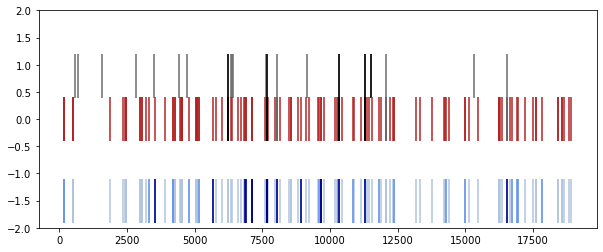

In [86]:
plt.figure(figsize=(10,4))

temp_stock_05 = isnvs_set_final[isnvs_set_final['merged_freq']>0.005]
temp_stock_2 = isnvs_set_final[isnvs_set_final['merged_freq']>0.02]

# stock >0.5% and >2%
plt.scatter(temp_stock_05['POS'],[.8]*len(temp_stock_05),marker='|',s=2000,color='dimgrey')
plt.scatter(temp_stock_2['POS'],[.8]*len(temp_stock_2),marker='|',s=2000,color='black')

temp_sing_s05 = sing_df[sing_df['POS'].isin(list(set(temp_stock_05['POS'])))]
temp_sing_s2 = sing_df[sing_df['POS'].isin(list(set(temp_stock_2['POS'])))]
temp_shared_s05 = shared_df[shared_df['POS'].isin(list(set(temp_stock_05['POS'])))]
temp_shared_s2 = shared_df[shared_df['POS'].isin(list(set(temp_stock_2['POS'])))]

# variants in animals
plt.scatter(sing_df['POS'],[0]*len(sing_df),marker='|',s=2000,color='firebrick')
plt.scatter(shared_df['POS'],[0]*len(shared_df),marker='|',s=2000,color='firebrick')
plt.scatter(temp_sing_s05['POS'],[0]*len(temp_sing_s05),marker='|',s=2000,color='dimgrey')
plt.scatter(temp_shared_s05['POS'],[0]*len(temp_shared_s05),marker='|',s=2000,color='dimgrey')
plt.scatter(temp_sing_s2['POS'],[0]*len(temp_sing_s2),marker='|',s=2000,color='black')
plt.scatter(temp_shared_s2['POS'],[0]*len(temp_shared_s2),marker='|',s=2000,color='black')

plt.scatter(sing_df['POS'],[-1.5]*len(sing_df),marker='|',s=2000,color='lightsteelblue')
plt.scatter(shared_df['POS'],[-1.5]*len(shared_df),marker='|',s=2000,color='lightsteelblue')
plt.scatter(sing_df[sing_df['freq']>0.05]['POS'],[-1.5]*len(sing_df[sing_df['freq']>0.05]),marker='|',s=2000,color='cornflowerblue')
plt.scatter(shared_df[shared_df['freq']>0.05]['POS'],[-1.5]*len(shared_df[shared_df['freq']>0.05]),marker='|',s=2000,color='cornflowerblue')
plt.scatter(sing_df[sing_df['freq']>0.1]['POS'],[-1.5]*len(sing_df[sing_df['freq']>0.1]),marker='|',s=2000,color='darkblue')
plt.scatter(shared_df[shared_df['freq']>0.1]['POS'],[-1.5]*len(shared_df[shared_df['freq']>0.1]),marker='|',s=2000,color='darkblue')


# functionally tested
#plt.scatter(shared_df[shared_df['freq']>0.05]['POS'],[0]*len(shared_df[shared_df['freq']>0.05]),marker='|',s=2000,color='orange')
#plt.scatter(sing_df[sing_df['freq']>0.05]['POS'],[0]*len(sing_df[sing_df['freq']>0.05]),marker='|',s=2000,color='red')
#plt.scatter(sing_df[sing_df['freq']>0.1]['POS'],[0]*len(sing_df[sing_df['freq']>0.1]),marker='|',s=2000,color='green')

plt.ylim(-2,2)


In [7]:
print(len(sing_df[sing_df['freq']>0.1]['POS']))
print(len(shared_df[shared_df['freq']>0.1]))

9
11


(-2.0, 2.0)

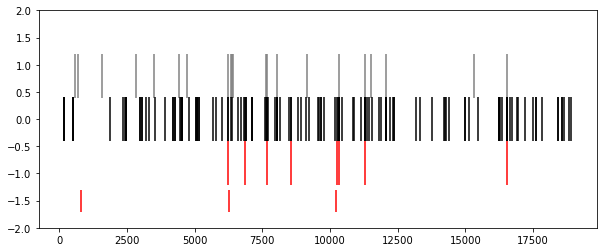

In [47]:
plt.figure(figsize=(10,4))

# stock >1%
plt.scatter(isnvs_set_final[isnvs_set_final['merged_freq']>0.005]['POS'],[.8]*len(isnvs_set_final[isnvs_set_final['merged_freq']>0.005]),marker='|',s=2000,color='grey')

# variants in animals
plt.scatter(shared_df['POS'],[0]*len(shared_df),marker='|',s=2000,color='black')
plt.scatter(sing_df['POS'],[0]*len(sing_df),marker='|',s=2000,color='black')

# functionally tested
plt.scatter(6231, -0.8, marker='|',s=2000,color='red')
plt.scatter(6870, -0.8, marker='|',s=2000,color='red')
plt.scatter(7668, -0.8, marker='|',s=2000,color='red')
plt.scatter(10243, -0.8, marker='|',s=2000,color='red')
plt.scatter(10343, -0.8, marker='|',s=2000,color='red')
plt.scatter(11282, -0.8, marker='|',s=2000,color='red')
plt.scatter(16526, -0.8, marker='|',s=2000,color='red')
plt.scatter(8565, -0.8, marker='|',s=2000,color='red')

# lit things of interest
plt.scatter(6283, -1.5, marker='|',s=500,color='red')
plt.scatter(10218, -1.5, marker='|',s=500,color='red')
plt.scatter(800, -1.5, marker='|',s=500,color='red')


plt.ylim(-2,2)

Text(0, 0.5, 'variant frequency')

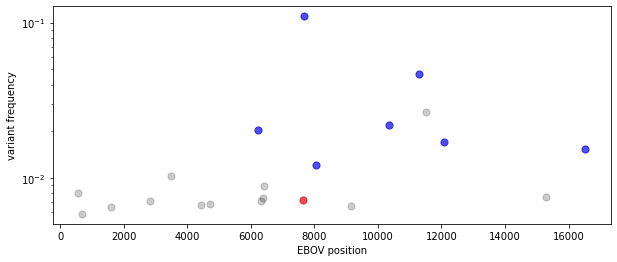

In [48]:
plt.figure(figsize=(10,4))
plt.scatter(isnvs_set_final['POS'],isnvs_set_final['merged_freq'],s=50,alpha=0.2,color='black')
plt.scatter(shared['POS'],shared['merged_freq'],s=50,alpha=0.6,color='blue')
plt.scatter(sing['POS'],sing['merged_freq'],s=50,alpha=0.6,color='red')

plt.yscale('log')
plt.xlabel('EBOV position')
plt.ylabel('variant frequency')


In [49]:
comb_df = pd.concat([sing_df,shared_df])


In [50]:
comb_df[comb_df['POS']==7668]

,#CHROM,POS,gene,gene_transcript,gene_note,type,ID,REF,ALT,QUAL,...,description,animal,cohort,tissue,depth,freq,qual,reads,variant_reads,alleles
0,KU182905.1,7668,NaN,NaN,NaN,NaN,.,T,C,1716,...,Spleen_RA1803_D006,RA1803,D006,Spleen,1942,0.044284,SB=7,"DP4=1003,842,42,48",86.0,TC
3,KU182905.1,7668,NaN,NaN,NaN,NaN,.,T,C,996,...,Liver_RA1803_D006,RA1803,D006,Liver,778,0.060411,SB=8,"DP4=359,365,30,19",47.0,TC
4,KU182905.1,7668,NaN,NaN,NaN,NaN,.,T,C,2687,...,Spleen_RA0717_D004,RA0717,D004,Spleen,1544,0.077720,SB=0,"DP4=633,778,57,71",120.0,TC
7,KU182905.1,7668,NaN,NaN,NaN,NaN,.,T,C,15673,...,Spleen_RA0700_D007,RA0700,D007,Spleen,10748,0.067827,SB=32,"DP4=4424,5564,280,461",729.0,TC
9,KU182905.1,7668,NaN,NaN,NaN,NaN,.,T,C,2121,...,Kidney_RA0700_D007,RA0700,D007,Kidney,1431,0.067086,SB=10,"DP4=736,575,68,36",96.0,TC
11,KU182905.1,7668,NaN,NaN,NaN,NaN,.,T,C,1031,...,Lymph node 1_RA0700_D007,RA0700,D007,Lymph node (ax),885,0.055367,SB=11,"DP4=387,447,30,20",49.0,TC
14,KU182905.1,7668,NaN,NaN,NaN,NaN,.,T,C,2558,...,Lymph node 2_RA0700_D007,RA0700,D007,Lymph node (ing),2039,0.059343,SB=14,"DP4=794,1115,39,84",121.0,TC
17,KU182905.1,7668,NaN,NaN,NaN,NaN,.,T,C,886,...,Lymph node 3_RA0700_D007,RA0700,D007,Lymph node (mes),837,0.051374,SB=0,"DP4=401,389,22,22",43.0,TC
20,KU182905.1,7668,NaN,NaN,NaN,NaN,.,T,C,6666,...,Spleen_RA1779_D008,RA1779,D008,Spleen,2647,0.106158,SB=13,"DP4=1040,1314,110,180",281.0,TC
23,KU182905.1,7668,NaN,NaN,NaN,NaN,.,T,C,1612,...,Sex Organ_RA1779_D008,RA1779,D008,Sex Organ,1054,0.068311,SB=0,"DP4=553,412,47,33",72.0,TC


In [51]:
isnvs_set_final[isnvs_set_final['POS'].isin(list(set(comb_df['POS'])))]


,POS,replicate_x,rep3_ref,rep3_alt,rep3_freq,rep3_depth,rep3_variant_reads,replicate_y,rep2_ref,rep2_alt,rep2_freq,rep2_depth,rep2_variant_reads,merged_freq
9,6231,S4.GDJM5.1,T,C,0.020884,12833.0,268.0,S3.GDJM5.1,T,C,0.019904,13364.0,266.0,0.020384
13,7648,S4.GDJM5.1,A,C,0.007025,20641.0,145.0,S3.GDJM5.1,A,C,0.007462,21577.0,161.0,0.007248
14,7668,S4.GDJM5.1,T,C,0.107932,21180.0,2286.0,S3.GDJM5.1,T,C,0.112221,22028.0,2472.0,0.110118
15,8050,S4.GDJM5.1,A,C,0.012489,6886.0,86.0,S3.GDJM5.1,A,C,0.011616,6629.0,77.0,0.012061
19,10343,S4.GDJM5.1,C,A,0.022430,9942.0,223.0,S3.GDJM5.1,C,A,0.021262,10253.0,218.0,0.021837
20,11282,S4.GDJM5.1,A,C,0.049569,1392.0,69.0,S3.GDJM5.1,A,C,0.043702,1167.0,51.0,0.046893
22,12064,S4.GDJM5.1,G,A,0.015324,5547.0,85.0,S3.GDJM5.1,G,A,0.018583,5704.0,106.0,0.016976
25,16526,S4.GDJM5.1,A,C,0.015109,7148.0,108.0,S3.GDJM5.1,A,C,0.015474,7238.0,112.0,0.015293


In [52]:
stock_split_df = comb_df[comb_df['POS'].isin(list(set(isnvs_set_final['POS'])))]


Text(0, 0.5, 'variant frequency')

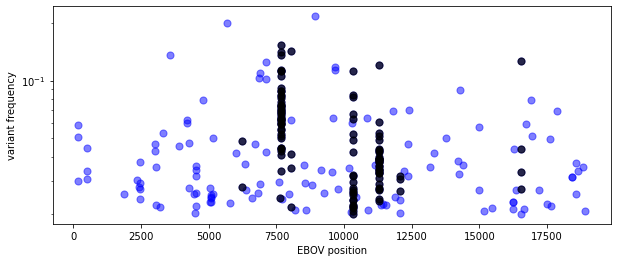

In [53]:
plt.figure(figsize=(10,4))
plt.scatter(comb_df['POS'],comb_df['freq'],s=50,alpha=0.5,color='blue')
plt.scatter(stock_split_df['POS'],stock_split_df['freq'],s=50,alpha=0.7,color='black')

plt.yscale('log')
plt.xlabel('EBOV position')
plt.ylabel('variant frequency')


In [54]:
comb_df[comb_df['POS']==10144]

,#CHROM,POS,gene,gene_transcript,gene_note,type,ID,REF,ALT,QUAL,...,description,animal,cohort,tissue,depth,freq,qual,reads,variant_reads,alleles


In [55]:
isnvs_set_final_stock = pd.merge(comb_df,isnvs_set_final[['POS','merged_freq']], on=['POS'],how='left')
isnvs_set_final_stock


,#CHROM,POS,gene,gene_transcript,gene_note,type,ID,REF,ALT,QUAL,...,animal,cohort,tissue,depth,freq,qual,reads,variant_reads,alleles,merged_freq
0,KU182905.1,169,UTR,NP,NP 5'UTR,noncoding,.,A,G,569,...,RA1779,D008,Spleen,463,0.058315,SB=6,"DP4=422,12,27,2",27.0,AG,NaN
1,KU182905.1,169,UTR,NP,NP 5'UTR,noncoding,.,A,G,149,...,RA1779,D008,Lymph node (mes),268,0.029851,SB=2,"DP4=238,22,7,1",8.0,AG,NaN
2,KU182905.1,169,UTR,NP,NP 5'UTR,noncoding,.,A,G,148,...,RA1779,D008,Whole blood (D008),138,0.050725,SB=14,"DP4=126,4,6,2",7.0,AG,NaN
3,KU182905.1,1856,NP,NP,NaN,nonsynonymous,.,G,A,989,...,RA1779,D008,Lymph node (mes),2394,0.025480,SB=5,"DP4=2036,290,62,5",61.0,GA,NaN
4,KU182905.1,2340,NP,NP,NaN,nonsynonymous,.,A,T,2907,...,RA1818,D006,Lymph node (mes),5438,0.030158,SB=17,"DP4=910,4355,42,130",164.0,AT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,KU182905.1,7668,NaN,NaN,NaN,NaN,.,T,C,12656,...,RA1074,D006,Whole blood (D006),7899,0.073047,SB=38,"DP4=2725,4567,174,415",577.0,TC,0.110118
234,KU182905.1,11282,NaN,NaN,NaN,NaN,.,A,C,4434,...,RA1074,D006,Whole blood (D006),6115,0.038757,SB=9,"DP4=3563,2308,159,82",237.0,AC,0.046893
235,KU182905.1,7668,NaN,NaN,NaN,NaN,.,T,C,3614,...,RA1803,D006,Whole blood (D006),3548,0.050169,SB=0,"DP4=1267,2097,66,113",178.0,TC,0.110118
236,KU182905.1,10343,NaN,NaN,NaN,NaN,.,C,A,595,...,RA1803,D006,Whole blood (D006),1744,0.021789,SB=0,"DP4=759,943,19,22",38.0,CA,0.021837


In [56]:
isnvs_set_final_stock[isnvs_set_final_stock['freq']>isnvs_set_final_stock['merged_freq']*5]


,#CHROM,POS,gene,gene_transcript,gene_note,type,ID,REF,ALT,QUAL,...,animal,cohort,tissue,depth,freq,qual,reads,variant_reads,alleles,merged_freq
137,KU182905.1,10343,NaN,NaN,NaN,NaN,.,C,A,613,...,RA1779,D008,Lymph node (ax),241,0.112033,SB=0,"DP4=75,133,12,19",27.0,CA,0.021837
188,KU182905.1,8050,NaN,NaN,NaN,NaN,.,A,C,1939,...,RA1423,D008,Lymph node (ax),544,0.143382,SB=2,"DP4=249,213,47,34",78.0,AC,0.012061
190,KU182905.1,16526,NaN,NaN,NaN,NaN,.,A,C,3603,...,RA1423,D008,Lymph node (ax),1162,0.127367,SB=2,"DP4=641,365,95,61",148.0,AC,0.015293


In [57]:
comb_df[comb_df['POS']==6231]['freq']

67    0.048155
80    0.027665
Name: freq, dtype: float64

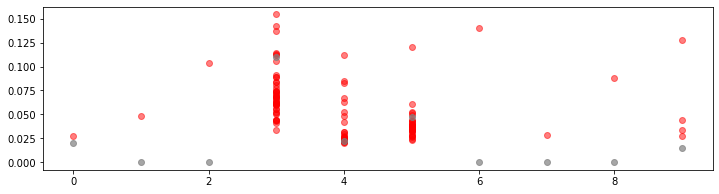

In [58]:
plt.figure(figsize=(12,3))

# 6231 T->C
plt.scatter(0,isnvs_set_final[isnvs_set_final['POS']==6231]['merged_freq'],color='grey',alpha=0.7)
plt.scatter(0,comb_df[comb_df['POS']==6231]['freq'][80],color='red',alpha=0.5)

# 6231 T->G
plt.scatter(1,0,color='grey',alpha=0.7)
plt.scatter(1,comb_df[comb_df['POS']==6231]['freq'][67],color='red',alpha=0.5)

# 6870
plt.scatter(2,0,color='grey',alpha=0.7)
plt.scatter([2]*len(comb_df[comb_df['POS']==6870]),comb_df[comb_df['POS']==6870]['freq'],color='red',alpha=0.5)

# 7668
plt.scatter([3]*len(comb_df[comb_df['POS']==7668]),comb_df[comb_df['POS']==7668]['freq'],color='red',alpha=0.5)
plt.scatter(3,isnvs_set_final[isnvs_set_final['POS']==7668]['merged_freq'],color='grey',alpha=0.7)

# 10343
plt.scatter([4]*len(comb_df[comb_df['POS']==10343]),comb_df[comb_df['POS']==10343]['freq'],color='red',alpha=0.5)
plt.scatter(4,isnvs_set_final[isnvs_set_final['POS']==10343]['merged_freq'],color='grey',alpha=0.7)

# 10243
plt.scatter(6,0.14,color='red',alpha=0.5)
plt.scatter(6,0,color='grey',alpha=0.7)

# 11282
plt.scatter([5]*len(comb_df[comb_df['POS']==11282]),comb_df[comb_df['POS']==11282]['freq'],color='red',alpha=0.5)
plt.scatter(5,isnvs_set_final[isnvs_set_final['POS']==11282]['merged_freq'],color='grey',alpha=0.7)

# 16526
plt.scatter([9]*len(comb_df[comb_df['POS']==16526]),comb_df[comb_df['POS']==16526]['freq'],color='red',alpha=0.5)
plt.scatter(9,isnvs_set_final[isnvs_set_final['POS']==16526]['merged_freq'],color='grey',alpha=0.7)

# 8565
plt.scatter([7]*len(comb_df[comb_df['POS']==8565]),comb_df[comb_df['POS']==8565]['freq'],color='red',alpha=0.5)
plt.scatter(7,0,color='grey',alpha=0.7)

# 8565
plt.scatter(8,0.088,color='red',alpha=0.5)
plt.scatter(8,0,color='grey',alpha=0.7)


In [59]:
isnvs_set_final[isnvs_set_final['merged_freq']<0.005]

,POS,replicate_x,rep3_ref,rep3_alt,rep3_freq,rep3_depth,rep3_variant_reads,replicate_y,rep2_ref,rep2_alt,rep2_freq,rep2_depth,rep2_variant_reads,merged_freq


In [60]:
isnvs_set_final_stock[isnvs_set_final_stock['freq']<isnvs_set_final_stock['merged_freq']*5]


,#CHROM,POS,gene,gene_transcript,gene_note,type,ID,REF,ALT,QUAL,...,animal,cohort,tissue,depth,freq,qual,reads,variant_reads,alleles,merged_freq
49,KU182905.1,7648,GP,GP,NaN,synonymous,.,A,G,7654,...,RA1423,D008,Lymph node (mes),18595,0.024469,SB=17,"DP4=8113,9998,235,232",455.0,AG,0.007248
112,KU182905.1,7668,NaN,NaN,NaN,NaN,.,T,C,1716,...,RA1803,D006,Spleen,1942,0.044284,SB=7,"DP4=1003,842,42,48",86.0,TC,0.110118
113,KU182905.1,10343,NaN,NaN,NaN,NaN,.,C,A,332,...,RA1803,D006,Spleen,646,0.029412,SB=0,"DP4=278,345,9,13",19.0,CA,0.021837
114,KU182905.1,11282,NaN,NaN,NaN,NaN,.,A,C,861,...,RA1803,D006,Spleen,1065,0.042254,SB=0,"DP4=609,409,27,19",45.0,AC,0.046893
115,KU182905.1,7668,NaN,NaN,NaN,NaN,.,T,C,996,...,RA1803,D006,Liver,778,0.060411,SB=8,"DP4=359,365,30,19",47.0,TC,0.110118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,KU182905.1,7668,NaN,NaN,NaN,NaN,.,T,C,12656,...,RA1074,D006,Whole blood (D006),7899,0.073047,SB=38,"DP4=2725,4567,174,415",577.0,TC,0.110118
234,KU182905.1,11282,NaN,NaN,NaN,NaN,.,A,C,4434,...,RA1074,D006,Whole blood (D006),6115,0.038757,SB=9,"DP4=3563,2308,159,82",237.0,AC,0.046893
235,KU182905.1,7668,NaN,NaN,NaN,NaN,.,T,C,3614,...,RA1803,D006,Whole blood (D006),3548,0.050169,SB=0,"DP4=1267,2097,66,113",178.0,TC,0.110118
236,KU182905.1,10343,NaN,NaN,NaN,NaN,.,C,A,595,...,RA1803,D006,Whole blood (D006),1744,0.021789,SB=0,"DP4=759,943,19,22",38.0,CA,0.021837


Text(0, 0.5, 'variant frequency')

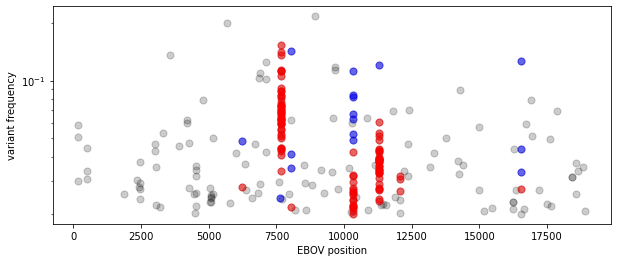

In [61]:
sig_change = isnvs_set_final_stock[isnvs_set_final_stock['freq']>isnvs_set_final_stock['merged_freq']*2]
nonsig_change = isnvs_set_final_stock[isnvs_set_final_stock['freq']<isnvs_set_final_stock['merged_freq']*2]

plt.figure(figsize=(10,4))
plt.scatter(isnvs_set_final_stock['POS'],isnvs_set_final_stock['freq'],s=50,alpha=0.2,color='black')
plt.scatter(sig_change['POS'],sig_change['freq'],s=50,alpha=0.5,color='blue')
plt.scatter(nonsig_change['POS'],nonsig_change['freq'],s=50,alpha=0.5,color='red')

plt.yscale('log')
plt.xlabel('EBOV position')
plt.ylabel('variant frequency')


Text(0, 0.5, 'variant frequency')

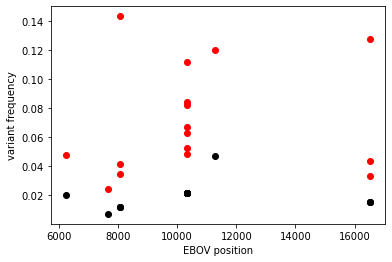

In [62]:
plt.scatter(sig_change['POS'],sig_change['freq'],color='red')
plt.scatter(sig_change['POS'],sig_change['merged_freq'],color='black')
plt.xlabel('EBOV position')
plt.ylabel('variant frequency')


In [63]:
sig_change_df = comb_df[comb_df['POS'].isin(list(set(isnvs_set_final[isnvs_set_final['merged_freq']<0.005]['POS'])))]
sig_change_df


,#CHROM,POS,gene,gene_transcript,gene_note,type,ID,REF,ALT,QUAL,...,description,animal,cohort,tissue,depth,freq,qual,reads,variant_reads,alleles
